https://www.kaggle.com/code/anu1312/rfm-segmentation-and-k-means-clustering

# **RFM Segmentation**

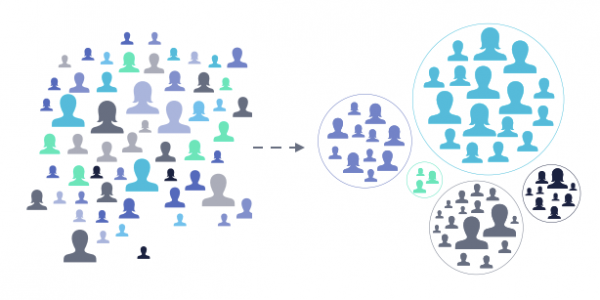

 Customer Segmentation is a practice of dividing a company's customers into groups that reflects the similarity among customers in each group. It can be done based on their needs, interests, priorities, by geography,etc.


With our dataset we are proceeding with RFM Segmentation.

# **Loading Packages**

We are loading the necessary packages for our code.

In [219]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
!pip install openpyxl

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable


# **Reading the data**
We are reading the excel file.

In [220]:
# df=pd.read_excel("../input/online-retail-ii-data-set-from-ml-repository/online_retail_II.xlsx")
df = pd.read_csv('data/data_cleaned_rfm.csv')

# **Checking the data**

To know more about our dataset, we are running few lines of code to check the **dimensions** of our dataset, **data types** of the variables and **basic infomation** about the variables.

In [221]:
df.shape

(74025, 6)

In [222]:
df['last_order'] = df['last_order'].astype(
    'datetime64')

In [223]:
df.dtypes

customer_unique_id             object
last_order             datetime64[ns]
frequency                       int64
monetary_value                float64
recency                         int64
mean_monetary_value           float64
dtype: object

In [224]:
df.describe()

,frequency,monetary_value,recency,mean_monetary_value
count,74025.000000,74025.000000,74025.000000,74025.000000
mean,1.028261,165.240969,174.623965,161.014695
std,0.188952,215.325916,99.434178,209.530868
min,1.000000,0.000000,0.000000,0.000000
25%,1.000000,63.230000,90.000000,62.700000
50%,1.000000,108.360000,174.000000,106.740000
75%,1.000000,182.860000,262.000000,177.870000
max,11.000000,4809.440000,364.000000,4809.440000


When we look into the features Quantity and Price,

* We can see the negative values, which indicates returned product
* Also, comparing the 75% and the max values, we can clearly see the presence of outliers in the data.

In [225]:
df.head()

,customer_unique_id,last_order,frequency,monetary_value,recency,mean_monetary_value
0,be40dd02e486b93b8b4128f2715cfdfe,2018-04-12 09:47:35,1,100.46,141,100.46
1,71bb258c3488c3ea32219c64c000ff3d,2018-08-03 23:00:24,1,276.20,28,276.20
2,863c9a8df992728d25a783b95471b674,2018-04-11 16:43:39,1,143.59,142,143.59
3,410f9b983169496799178835774f1f20,2017-10-29 11:59:16,1,41.09,306,41.09
4,28a18a20106f88e886bcebef8c04eff6,2017-11-13 02:52:52,1,39.09,291,39.09


### **Finding unique values**

In [226]:
print('A total of '+ str(df.nunique()) +' unique invoices were generated.')

A total of customer_unique_id     74025
last_order             73784
frequency                  9
monetary_value         24382
recency                  365
mean_monetary_value    24469
dtype: int64 unique invoices were generated.


In [227]:
# print('We have '+ str(df.StockCode.nunique()) +' unique products sold online.')


In [228]:
# We are renaming the CustomerID for our conveniency
# df = df.rename(columns={'Customer ID':'CustomerID'})

# print('We have '+ str(df.id_unique_client.nunique()) +' unique Customers in our dataset.')

In [229]:
# print('We have customers spread across '+ str(df.Country.nunique()) +' countries. ')

## **Data Preprocessing**


### **Null Value Check**

In [230]:
df.isnull().sum().sort_values(ascending=False)

customer_unique_id     0
last_order             0
frequency              0
monetary_value         0
recency                0
mean_monetary_value    0
dtype: int64

We have a lot of customers without Customer ID.

### **Corelation Check**

<Axes: >

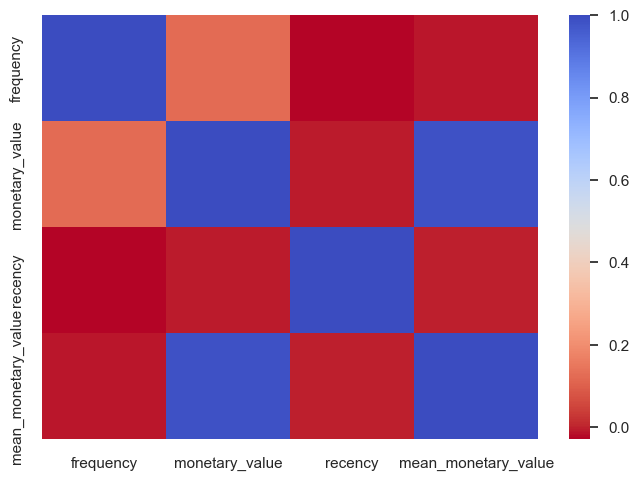

In [231]:
corrDf = df.corr()
sns.heatmap(corrDf, 
        xticklabels=corrDf.columns,
        yticklabels=corrDf.columns, cmap='coolwarm_r')

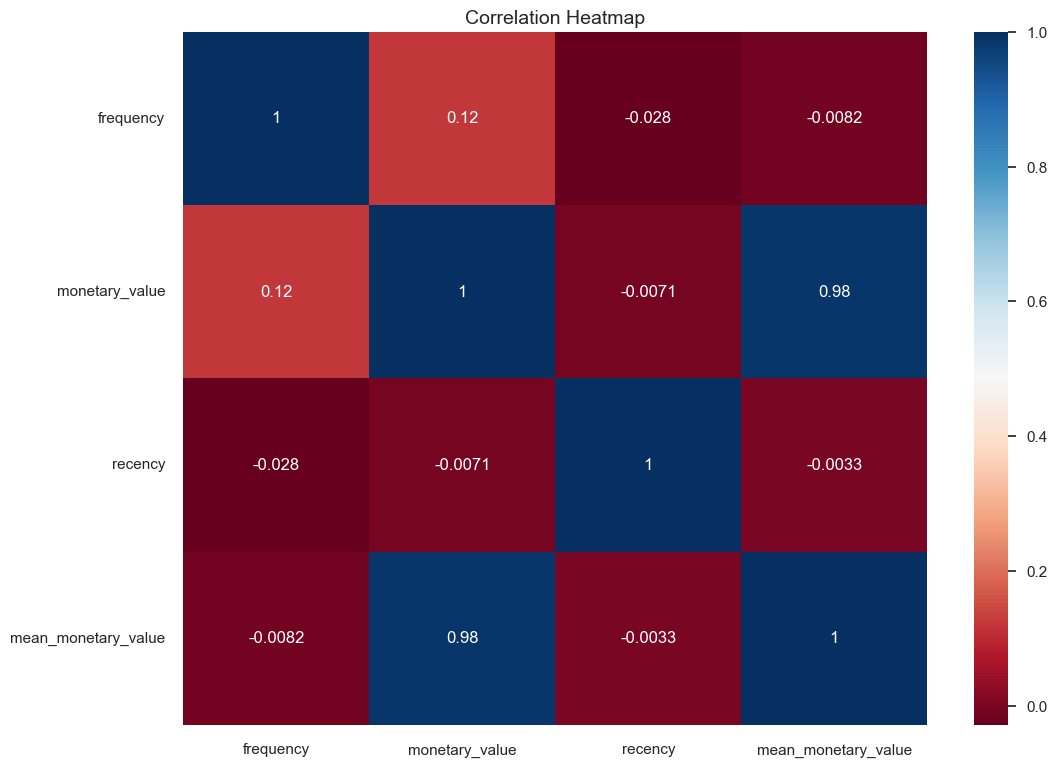

In [232]:
plt.figure(figsize=(12,9))
sns.heatmap(df.corr(),annot=True,cmap='RdBu')
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.show()

The variables are not corelated with each other.

### **Dropping negative values**

We are dropping rows which has negative quantity and price. 

In [233]:
# df = df[(df['Quantity']>0) & (df['Price']>0)] 
# df.describe()

In [234]:
df.shape

(74025, 6)

### **Removing duplicates**

We are removing duplicated data from our dataset.

In [235]:
df=df.drop_duplicates()
df.shape

(74025, 6)

## **RFM Analysis**

The first step in building an RFM model is to assign Recency, Frequency and Monetary values to each customer. So, RFM analysis can be carried out only on customers who have customerID.

**RFM Metrics**

**Recency**  : It is the amount of time since the customers most recent transaction. It is measured                 in days.
 
**Frequency**: Total number of transactions made by the customer.
 
**Monetary** : Total amount the customer has spent across all transactions.

To calculate the Recency value, we need to find the last invoice date in our dataset.

In [236]:
# df.InvoiceDate.max()

In [237]:
# Create a column Amount(Total cost)
# df['Amount'] = df['Quantity'] * df['Price']

In [238]:
# pin_date = dt.datetime(2010, 12,10)

# rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (pin_date - InvoiceDate.max()).days,
#                                      'Invoice': lambda Invoice: Invoice.nunique(),
#                                      'Amount': lambda Amount: Amount.sum()})

# rfm.head()
# Renommer les colonnes
rfm = df.rename(columns={'frequency': 'frequency', 'monetary_value': 'monetary', 'recency': 'recency'})

# Afficher le DataFrame rfm
# print(rfm)
rfm.head()

,customer_unique_id,last_order,frequency,monetary,recency,mean_monetary_value
0,be40dd02e486b93b8b4128f2715cfdfe,2018-04-12 09:47:35,1,100.46,141,100.46
1,71bb258c3488c3ea32219c64c000ff3d,2018-08-03 23:00:24,1,276.20,28,276.20
2,863c9a8df992728d25a783b95471b674,2018-04-11 16:43:39,1,143.59,142,143.59
3,410f9b983169496799178835774f1f20,2017-10-29 11:59:16,1,41.09,306,41.09
4,28a18a20106f88e886bcebef8c04eff6,2017-11-13 02:52:52,1,39.09,291,39.09


### Changing the column names

In [239]:
# rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm["monetary"] > 0]
rfm.head()

,customer_unique_id,last_order,frequency,monetary,recency,mean_monetary_value
0,be40dd02e486b93b8b4128f2715cfdfe,2018-04-12 09:47:35,1,100.46,141,100.46
1,71bb258c3488c3ea32219c64c000ff3d,2018-08-03 23:00:24,1,276.20,28,276.20
2,863c9a8df992728d25a783b95471b674,2018-04-11 16:43:39,1,143.59,142,143.59
3,410f9b983169496799178835774f1f20,2017-10-29 11:59:16,1,41.09,306,41.09
4,28a18a20106f88e886bcebef8c04eff6,2017-11-13 02:52:52,1,39.09,291,39.09


### **Calculate the score**

We need to assign a score from 1 to 5 to recency, frequency and monetary value individually for each customer.

Below is the **conversion** of columns into rfm scores between 1 to 5. 

**'5'** being the **highest** and **'1'** being the **least**.

- The higher the **monetary** value, higher is the score ie,'5' . 


- Smaller value of **recency** indicates recent purchases, so it takes the higher value of 5. 


- Frequency is the same as monetary, higher the **frequency**, higher the score.

In [240]:
# rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])


# rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# rfm['score']=rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)

# Calculer les scores de recency en divisant les données en 5 intervalles et en attribuant des étiquettes de score
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

# Calculer les scores de frequency en divisant les données en 5 intervalles et en attribuant des étiquettes de score
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

# Calculer les scores de monetary en divisant les données en 5 intervalles et en attribuant des étiquettes de score
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

# Calculer le score total en additionnant les scores de recency, frequency et monetary
rfm['score'] = rfm['recency_score'].astype(int) + rfm['frequency_score'].astype(int) + rfm['monetary_score'].astype(int)


In [241]:
rfm.head()

,customer_unique_id,last_order,frequency,monetary,recency,mean_monetary_value,recency_score,frequency_score,monetary_score,score
0,be40dd02e486b93b8b4128f2715cfdfe,2018-04-12 09:47:35,1,100.46,141,100.46,4,1,3,8
1,71bb258c3488c3ea32219c64c000ff3d,2018-08-03 23:00:24,1,276.20,28,276.20,5,1,5,11
2,863c9a8df992728d25a783b95471b674,2018-04-11 16:43:39,1,143.59,142,143.59,3,1,4,8
3,410f9b983169496799178835774f1f20,2017-10-29 11:59:16,1,41.09,306,41.09,1,1,1,3
4,28a18a20106f88e886bcebef8c04eff6,2017-11-13 02:52:52,1,39.09,291,39.09,1,1,1,3


In [242]:
unique_scores = rfm['score'].unique()
print(unique_scores)


[ 8 11  3  6  5  7  4  9 10 13 15 14 12]


### Best customers

With the help of score, we will be able to identify the best customers in our e-commerce company.

In [243]:
rfm[rfm['score']>= 15].sort_values('monetary', ascending=False).head()

,customer_unique_id,last_order,frequency,monetary,recency,mean_monetary_value,recency_score,frequency_score,monetary_score,score
68090,5d0a2980b292d049061542014e8960bf,2018-07-12 12:08:36,1,4809.44,50,4809.4400,5,5,5,15
71782,c8460e4251689ba205045f3ea17884a1,2018-08-08 14:27:15,4,4655.91,23,1163.9775,5,5,5,15
73272,ca27f3dac28fb1063faddd424c9d95fa,2018-07-29 08:39:48,1,4163.51,33,4163.5100,5,5,5,15
72616,ce3fe361f9e68bf0a813baaae1334d01,2018-08-15 17:00:49,1,3351.35,16,3351.3500,5,5,5,15
63545,8e07cbdbbb24328ece74135e2a81405b,2018-08-10 00:17:59,1,2455.12,21,2455.1200,5,5,5,15


The customers having a score of '15' are considered as the 'best customers' as they have have the highest recency, frequency and monetary score.

They are asset to the company.

### **Number of best customers** 

In [244]:
rfm[rfm['score']>=15].count()

customer_unique_id     743
last_order             743
frequency              743
monetary               743
recency                743
mean_monetary_value    743
recency_score          743
frequency_score        743
monetary_score         743
score                  743
dtype: int64

There are 349 Best customers in the company who are frequent buyers and also generate high revenue.

## **Seggregate the levels**

We are going to **seggregate** the level of the customer **based on the score**.

Here we have classified them into **4 levels**.

**Active** : High revenue generating and frequent buyers .

**Good**: Customers whose purchases are fairly frequent and generate moderate revenue.

**Average** : Customers who are less active and are not very frequent buyers and generate low revenue.

**Inactive**: Customers generating very low revenue and are occasional buyers.

In [245]:
def rfm_level(score):
    if  ((score >1) and (score < 4)):
        return 'Inactif'
    elif ((score >3) and (score < 8)):
        return 'Moyen'
    elif ((score > 7) and (score <11)):
        return 'Bon'
    else:
        return 'Meilleur'

In [246]:
rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))
rfm.head()

,customer_unique_id,last_order,frequency,monetary,recency,mean_monetary_value,recency_score,frequency_score,monetary_score,score,level
0,be40dd02e486b93b8b4128f2715cfdfe,2018-04-12 09:47:35,1,100.46,141,100.46,4,1,3,8,Bon
1,71bb258c3488c3ea32219c64c000ff3d,2018-08-03 23:00:24,1,276.20,28,276.20,5,1,5,11,Meilleur
2,863c9a8df992728d25a783b95471b674,2018-04-11 16:43:39,1,143.59,142,143.59,3,1,4,8,Bon
3,410f9b983169496799178835774f1f20,2017-10-29 11:59:16,1,41.09,306,41.09,1,1,1,3,Inactif
4,28a18a20106f88e886bcebef8c04eff6,2017-11-13 02:52:52,1,39.09,291,39.09,1,1,1,3,Inactif


### Visualising number of customers for each level

<Axes: xlabel='level', ylabel='count'>

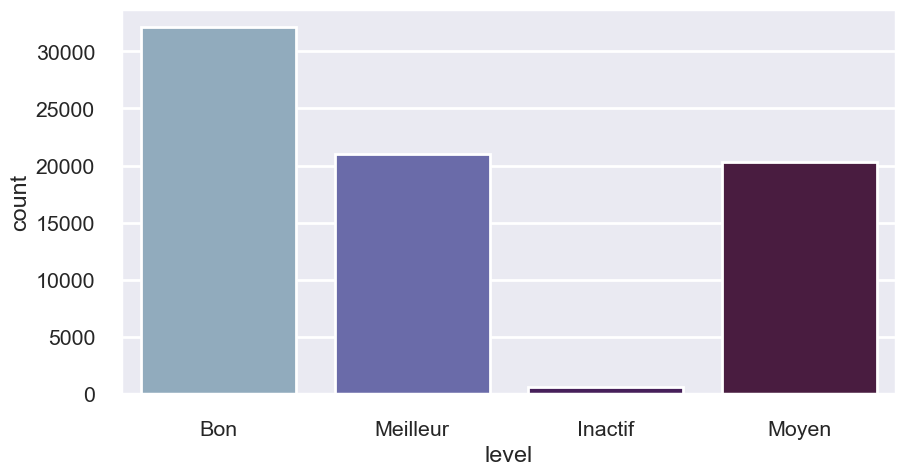

In [247]:
plt.figure(figsize=(10,5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(rfm['level'])

From the above bar graph, we can infer that
* There are only few Inactive customers in the online retail store when compared to the other levels.
* It is good to notice that there are more number of Active customers.

### Analysing each level

To understand each segment of customers better, we are going to deep dive on each segment. 

In [248]:
rfm.groupby('level').agg({
    'recency' : ['mean', 'min','max'],
    'frequency' : ['mean', 'min','max'],
    'monetary' : ['mean','min','max','count']
})

recency           frequency            monetary                  \
                mean  min  max      mean min max        mean    min      max   
level                                                                          
Bon       173.263965    0  364  1.007321   1   3  154.197161  10.89  4034.44   
Inactif   314.887564  278  364  1.000000   1   1   40.192709  13.68    55.28   
Meilleur  107.832381    1  364  1.088311   1  11  266.119716   9.59  4809.44   
Moyen     241.656705    3  364  1.000147   1   2   82.180378  10.07  2416.00   

                 
          count  
level            
Bon       32099  
Inactif     587  
Meilleur  20994  
Moyen     20344

### Active Customers

We can say that 20994 customers bought 266.11 units by shopping 1 times approximately every 108 days.

They are previliged customers.


Surprise offers can be given on birthdays and anniversary.

### Good Customers

1079 customers have bought 939.92 units by shopping thrice every 70 days

They are loyal customers.

### Average customers

1434 customers have bought approximately 939.92 units by shopping once every 151 days.

Tiered pricing of products can be introduced.

### Inactive customers

202 customers have bought approximately 142.49 units by shopping once every 273 days.


Personalised emails and SMS can be sent to the customers regarding the offers.

More marketing strategies can be introduced to improve the frequency of orders.


### Visualizing against each of the factors 

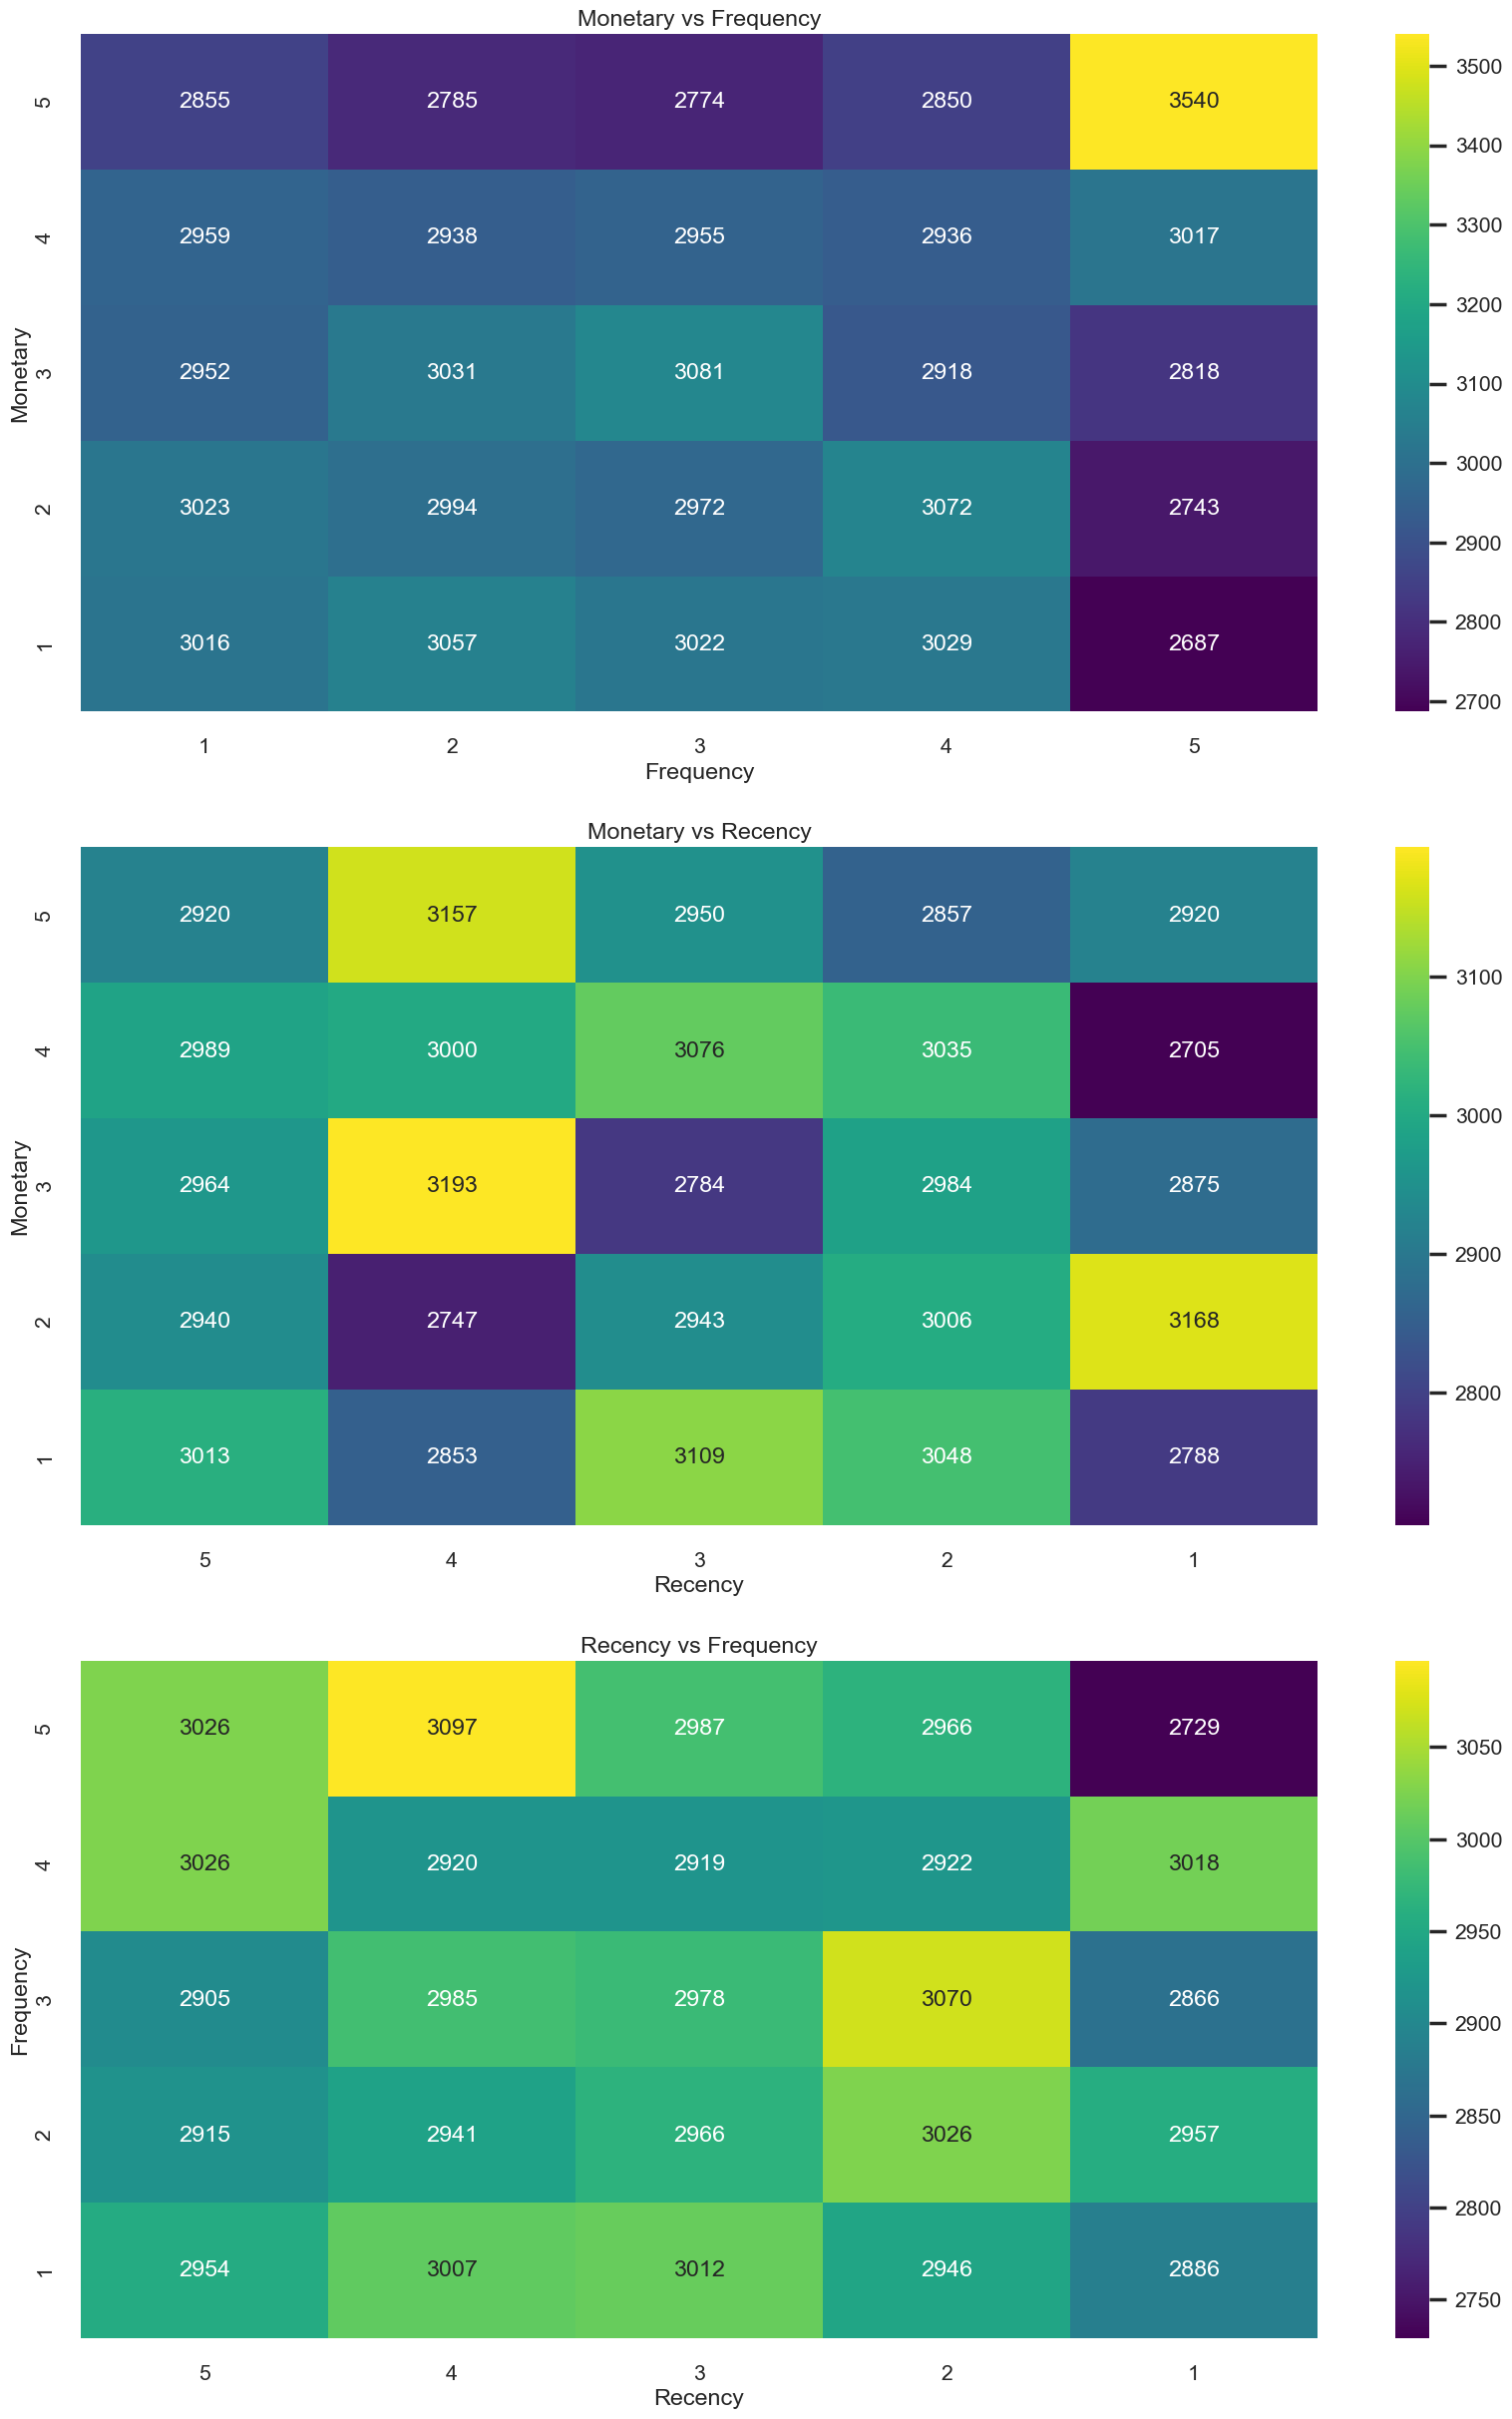

In [249]:
cross_table1 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['frequency_score'])
cross_table2 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['recency_score'])
cross_table3 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['recency_score'])
plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
ax1.set_title('Monetary vs Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
ax2.set_title('Monetary vs Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
ax3.set_title('Recency vs Frequency')
plt.show()

### Segmenting customers based on their levels

In [250]:
active = rfm[rfm['level'] == 'Meilleur']
average = rfm[rfm['level'] == 'moyen']
good = rfm[rfm['level'] == 'Bon']
inactive = rfm[rfm['level'] == 'Inactif']

### Saving in separate excel file

 We are saving the customers in separate files, so that it will be easy for the company to send relevent offers and messages to group of customers who belong to the same segment

In [251]:
active_df = pd.DataFrame()
active_df["customer_id"] = rfm[rfm["level"] == "Meilleur"].index

active_df.to_excel("active_customers.xlsx", sheet_name='Meilleur Client')

In [252]:
average_df = pd.DataFrame()
average_df["customer_id"] = rfm[rfm["level"] == "Moyen"].index

average_df.to_excel("average_customers.xlsx", sheet_name='Client Moyen')

In [253]:
good_df = pd.DataFrame()
good_df["customer_id"] = rfm[rfm["level"] == "Bon"].index

good_df.to_excel("good_customers.xlsx", sheet_name='Bon Client')

In [254]:
inactive_df = pd.DataFrame()
inactive_df["customer_id"] = rfm[rfm["level"] == "Inactif"].index

inactive_df.to_excel("inactive_customers.xlsx", sheet_name='Client pas actif')

## RFM Clustering

We are going to apply **unsupervised machine learning** to identify different groups/clusters based on segmentation of customers according to their purchasing behaviour.


The overall clusters will be based on the 3 factors - **recency, frequency and monetary values**

#### Looking at the RFM data


In [255]:
rfm.describe()

,frequency,monetary,recency,mean_monetary_value,score
count,74024.000000,74024.000000,74024.000000,74024.000000,74024.000000
mean,1.028261,165.243201,174.626283,161.016870,9.010091
std,0.188954,215.326514,99.432849,209.531447,2.487284
min,1.000000,9.590000,0.000000,9.590000,3.000000
25%,1.000000,63.230000,90.000000,62.700000,7.000000
50%,1.000000,108.365000,174.000000,106.745000,9.000000
75%,1.000000,182.860000,262.000000,177.870000,11.000000
max,11.000000,4809.440000,364.000000,4809.440000,15.000000


There is **no negative** value in the dataset.

#### Checking outliers

#### Outlier treatment for recency


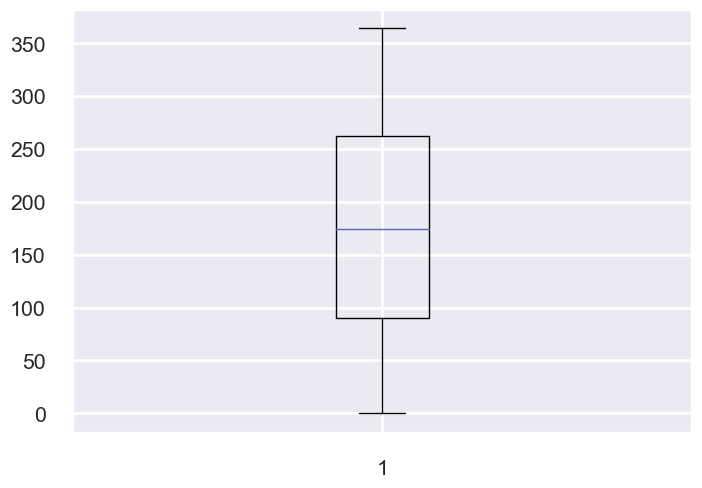

In [201]:
plt.boxplot(rfm.recency)
Q1 = rfm.recency.quantile(0.05)
Q3 = rfm.recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5*IQR) & (rfm.recency <= Q3 + 1.5*IQR)]

#### Outlier treatment for frequency

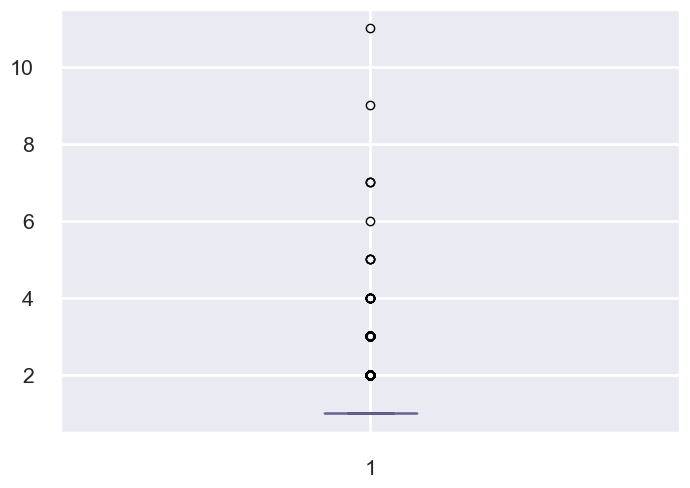

In [202]:
plt.boxplot(rfm.frequency)
Q1 = rfm.frequency.quantile(0.05)
Q3 = rfm.frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5*IQR) & (rfm.frequency <= Q3 + 1.5*IQR)]

##### Outlier treatment for monetary

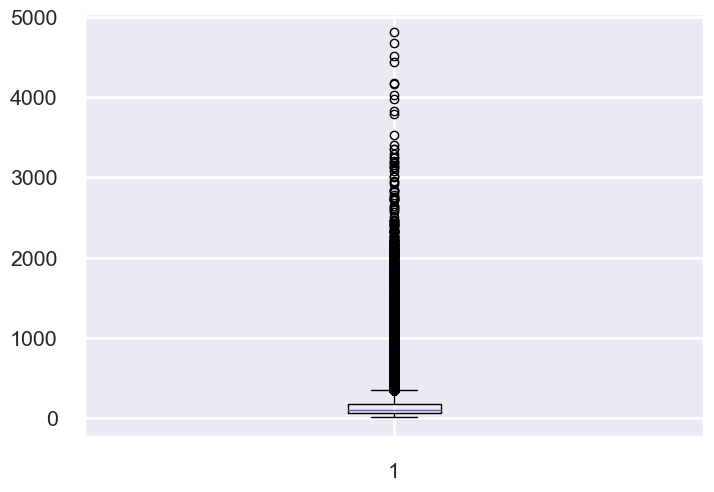

In [203]:
plt.boxplot(rfm.monetary)
Q1 = rfm.monetary.quantile(0.05)
Q3 = rfm.monetary.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.monetary >= (Q1 - 1.5*IQR)) & (rfm.monetary <= (Q3 + 1.5*IQR))]

## K Means

### Transforming the data

In [279]:
rfm1=rfm[['recency','frequency','monetary']]
scaler = StandardScaler()
x_scaled=scaler.fit(rfm1)
x_scaled = scaler.fit_transform(rfm1)
x_scaled

array([[-0.33818311, -0.14956737, -0.30086234],
       [-1.47463615, -0.14956737,  0.51529905],
       [-0.32812601, -0.14956737, -0.10056053],
       ...,
       [ 0.06410115, -0.14956737,  0.25095453],
       [-1.36400798, -0.14956737,  1.6337476 ],
       [ 0.05404404, -0.14956737,  0.41628596]])

#### Elbow method

We are going to **determine the number of clusters** using Elbow method.

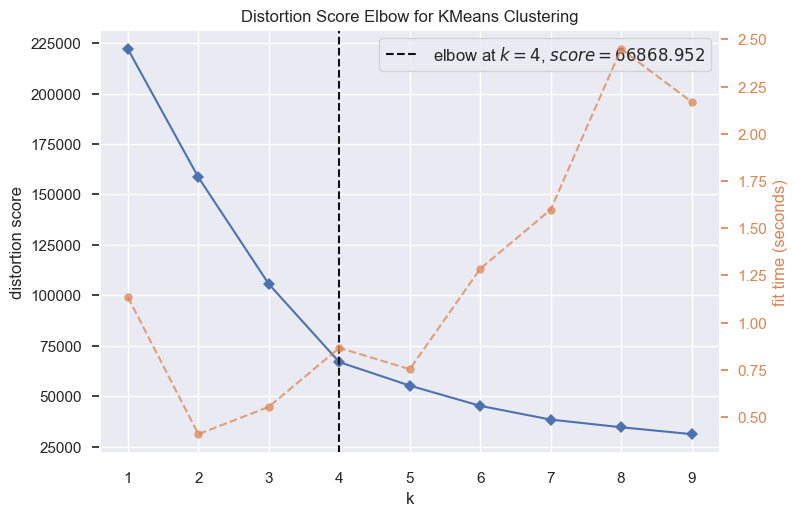

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [310]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(x_scaled)  
visualizer.show()   

According to the Elbow method, the number of clusters is **4**.

In [258]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Créez une liste pour stocker les scores de silhouette
silhouette_scores = []

# Essayer différentes valeurs de k (nombre de clusters)
for k in range(2, 10):
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(x_scaled)
    silhouette_avg = silhouette_score(x_scaled, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Pour k={k}, le score de silhouette moyen est : {silhouette_avg:.3f}")

# Dans ce code, nous itérons sur différentes valeurs de `k` (nombre de clusters) et calculons le score de silhouette moyen pour chaque valeur de `k`. Le score de silhouette moyen peut prendre des valeurs entre -1 et 1. Un score plus élevé indique que les points sont bien attribués à leurs clusters et que les clusters sont bien séparés.

# Après avoir exécuté ce code, vous pouvez visualiser les scores de silhouette pour différentes valeurs de `k` et choisir celle qui présente le score le plus élevé, ce qui indique une meilleure séparation entre les clusters. Vous pouvez utiliser la valeur de `k` correspondant au score le plus élevé comme estimation du nombre optimal de clusters.

# Cependant, gardez à l'esprit que la méthode de la silhouette n'est qu'une méthode d'évaluation parmi d'autres, et il est souvent recommandé d'utiliser plusieurs méthodes en combinaison avec vos connaissances du domaine pour choisir le nombre optimal de clusters.

Pour k=2, le score de silhouette moyen est : 0.750
Pour k=3, le score de silhouette moyen est : 0.461
Pour k=4, le score de silhouette moyen est : 0.498
Pour k=5, le score de silhouette moyen est : 0.509
Pour k=6, le score de silhouette moyen est : 0.434
Pour k=7, le score de silhouette moyen est : 0.436
Pour k=8, le score de silhouette moyen est : 0.443
Pour k=9, le score de silhouette moyen est : 0.388


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


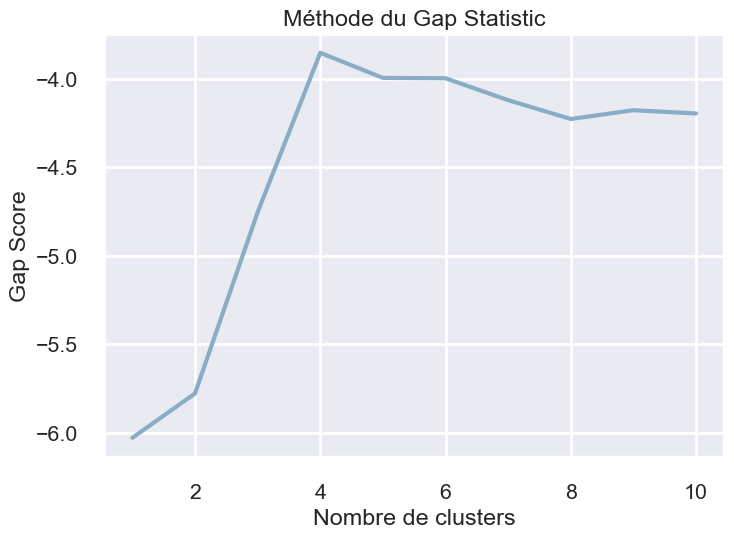

In [259]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Générer des données de test
X, y = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# Fonction pour calculer le Gap Statistic
def compute_gap(data, k_max):
    gaps = []
    for k in range(1, k_max + 1):
        model = KMeans(n_clusters=k)
        model.fit(data)
        intra_cluster_dist = model.inertia_
        reference_data = np.random.rand(*data.shape)
        reference_model = KMeans(n_clusters=k)
        reference_model.fit(reference_data)
        reference_intra_cluster_dist = reference_model.inertia_
        gap = np.log(reference_intra_cluster_dist) - np.log(intra_cluster_dist)
        gaps.append(gap)
    return gaps

k_max = 10  # Nombre maximum de clusters à tester
gap_scores = compute_gap(X, k_max)

# Afficher les scores Gap
plt.plot(range(1, k_max + 1), gap_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Gap Score')
plt.title('Méthode du Gap Statistic')
plt.show()


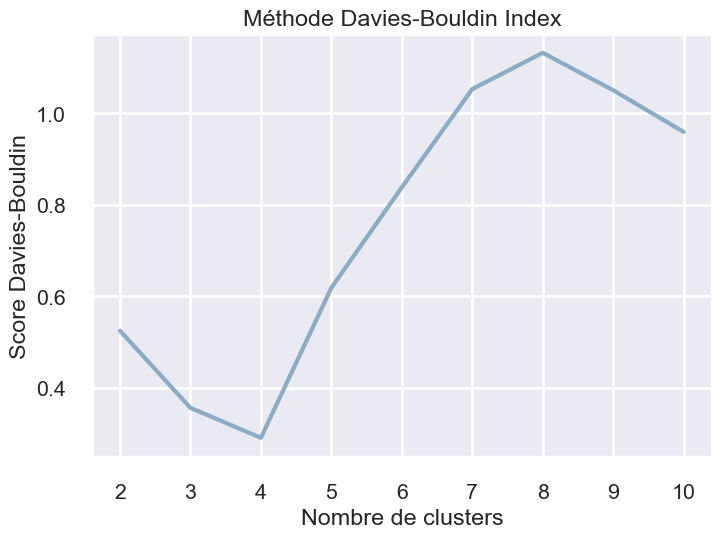

In [260]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import davies_bouldin_score

# Générer des données de test
X, y = make_blobs(n_samples=300, centers=4, cluster_std=1.0, random_state=42)

# Calculer le score Davies-Bouldin pour différentes valeurs de k
k_max = 10  # Nombre maximum de clusters à tester
davies_bouldin_scores = []
for k in range(2, k_max + 1):
    model = KMeans(n_clusters=k)
    labels = model.fit_predict(X)
    score = davies_bouldin_score(X, labels)
    davies_bouldin_scores.append(score)

# Afficher les scores Davies-Bouldin
plt.plot(range(2, k_max + 1), davies_bouldin_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Score Davies-Bouldin')
plt.title('Méthode Davies-Bouldin Index')
plt.show()


### Applying K-Means

[0 0 0 ... 3 1 3]
 Our cluster centers are as follows
[[ 0.85963529 -0.14956737 -0.15505876]
 [-0.85327487 -0.14956737 -0.14389712]
 [ 0.02247667 -0.10365209  4.24761819]
 [-0.15786862  5.65827846  0.6104415 ]]


,recency,frequency,monetary
cluster_pred,,,
0,34963,34963,34963
1,34981,34981,34981
2,2191,2191,2191
3,1889,1889,1889


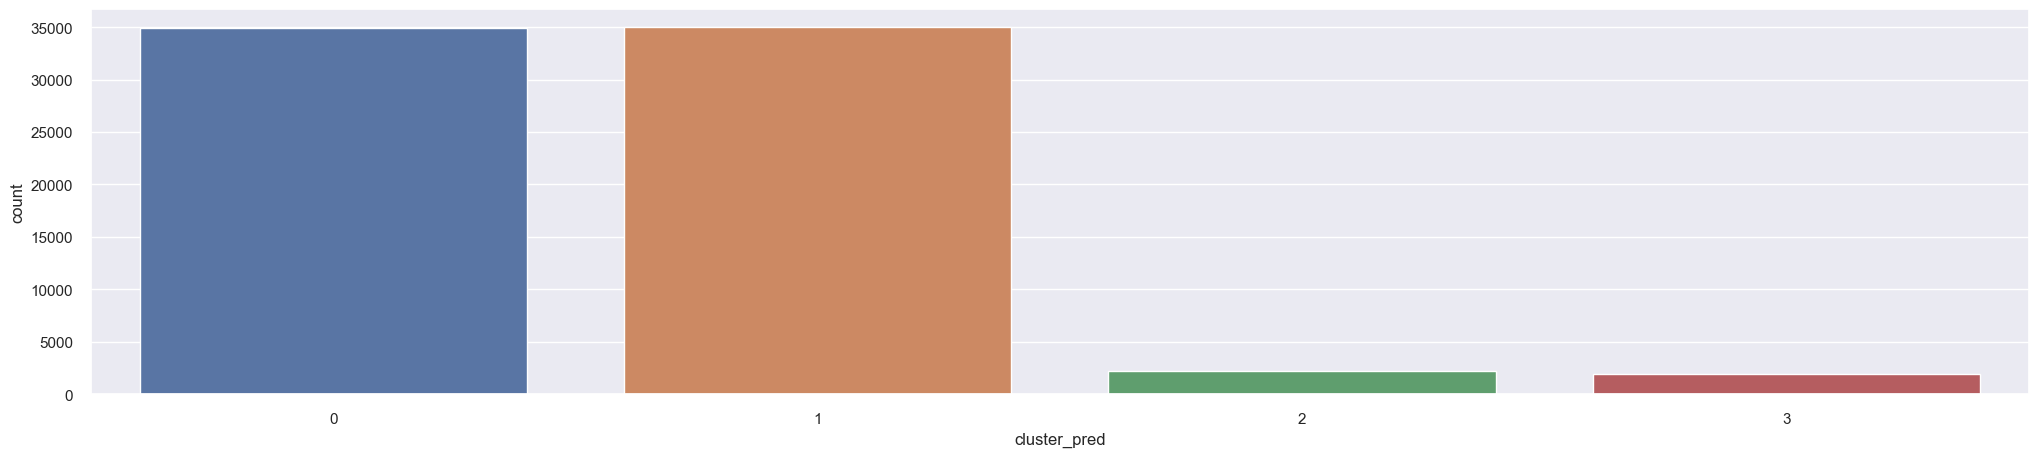

In [282]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

## Model et prédicion

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


[3 3 3 ... 3 3 3]
Nos centres de clusters sont les suivants
[[-0.8522215  -0.14956737 -0.1437987 ]
 [ 0.86064851 -0.14956737 -0.1558304 ]
 [-0.15786862  5.65827846  0.6104415 ]
 [ 0.02379958 -0.1038608   4.2380972 ]]


,recency,frequency,monetary
cluster_pred,,,
0,34997,34997,34997
1,34940,34940,34940
2,1889,1889,1889
3,2198,2198,2198


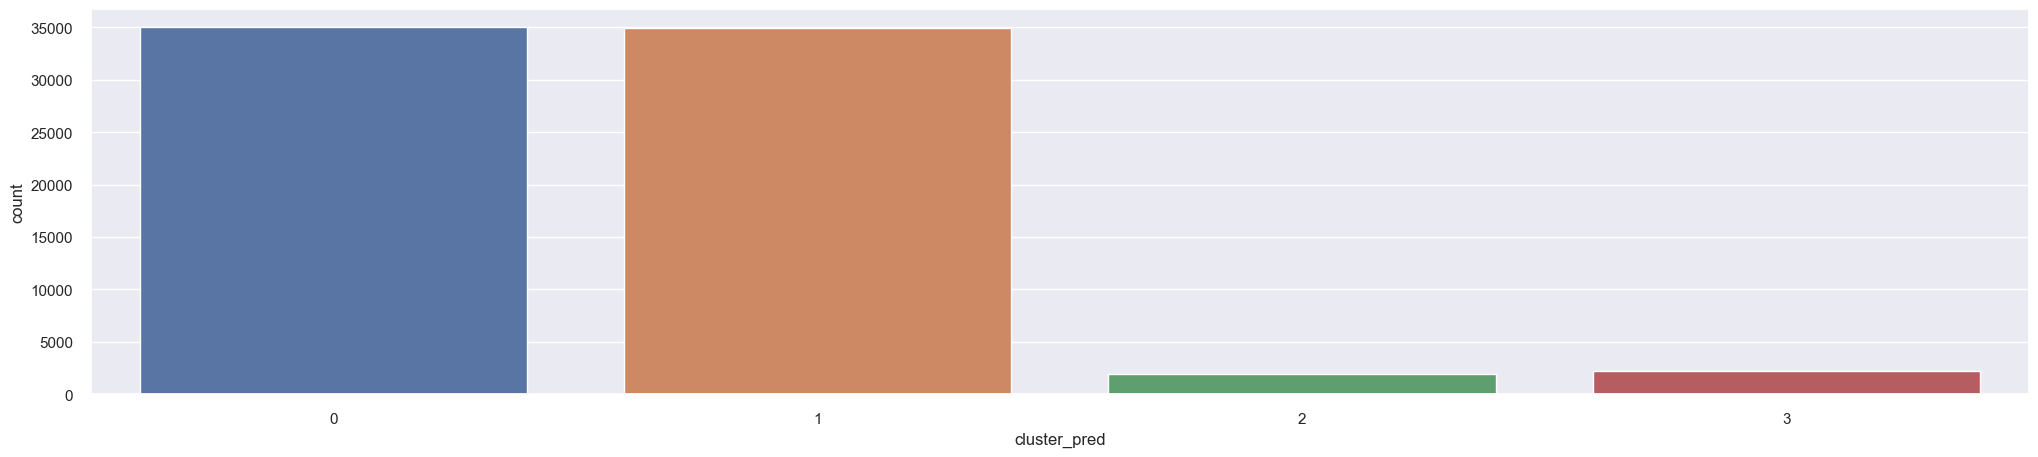

In [281]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Créez une instance du modèle KMeans avec le nombre de clusters spécifié (6 dans ce cas)
kmeans_scaled = KMeans(n_clusters=4)

# Ajustez le modèle KMeans aux données mises à l'échelle
kmeans_scaled.fit(x_scaled)

# Identifiez les clusters auxquels chaque point de données appartient
identified_clusters = kmeans_scaled.predict(rfm1)

# Créez une copie du DataFrame rfm1 pour stocker les informations de cluster prédites
clusters_scaled = rfm1.copy()

# Ajoutez une colonne au DataFrame indiquant le cluster prédit pour chaque point de données
clusters_scaled['cluster_pred'] = kmeans_scaled.predict(x_scaled)

# Affichez les identifications de cluster pour chaque point de données
print(identified_clusters)

# Configuration du style des graphiques avec seaborn
sns.set(style="darkgrid")

# Affichez les centres des clusters trouvés par le modèle KMeans
print("Nos centres de clusters sont les suivants")
print(kmeans_scaled.cluster_centers_)

# Créez une figure de taille spécifique pour afficher le décompte des points dans chaque cluster
f, ax = plt.subplots(figsize=(25, 5))

# Utilisez Seaborn pour créer un diagramme de comptage des clusters
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)

# Affichez le décompte des points dans chaque cluster
clusters_scaled.groupby(['cluster_pred']).count()


### Visualizing the clusters

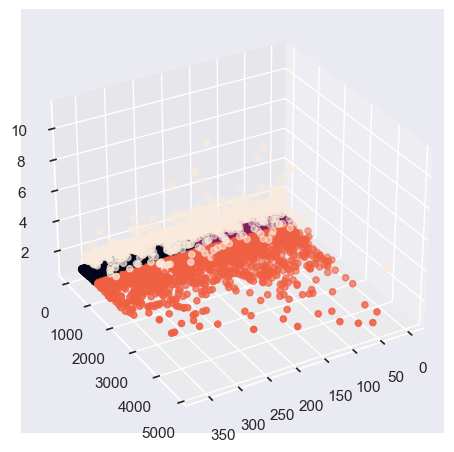

In [284]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['recency']
yline=clusters_scaled['frequency']
zline=clusters_scaled['monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

In [298]:
clusters_scaled.columns

Index(['recency', 'frequency', 'monetary', 'cluster_pred'], dtype='object')

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Création d'un graphique en 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Ajout des points sur le graphique en 3D
# ax.scatter(rfm_df['recency'], rfm_df['frequency'], rfm_df['monetary_value'], c=rfm_df['monetary_value'], cmap='viridis', alpha=0.8)
ax.scatter(rfm_df['recency'], rfm_df['frequency'], rfm_df['mean_monetary_value'], c=rfm_df['mean_monetary_value'], cmap='viridis', alpha=0.8)

# Configuration des axes
ax.set_xlabel('Récence (jours)')
ax.set_ylabel('Fréquence')
ax.set_zlabel('Valeur monétaire')
ax.set_title('Segmentation RFM')

# Ajout de la barre de couleur pour représenter la valeur monétaire
cbar = plt.colorbar(ax.scatter([], [], [], c=[], cmap='viridis'), ax=ax)
cbar.set_label('Valeur monétaire')

plt.show()


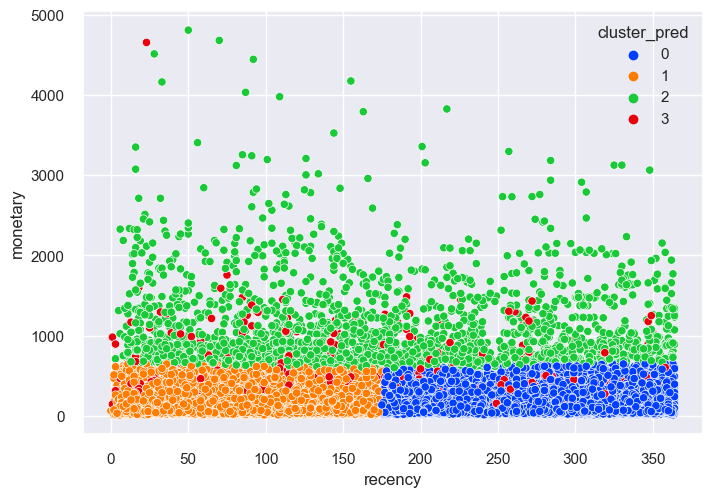

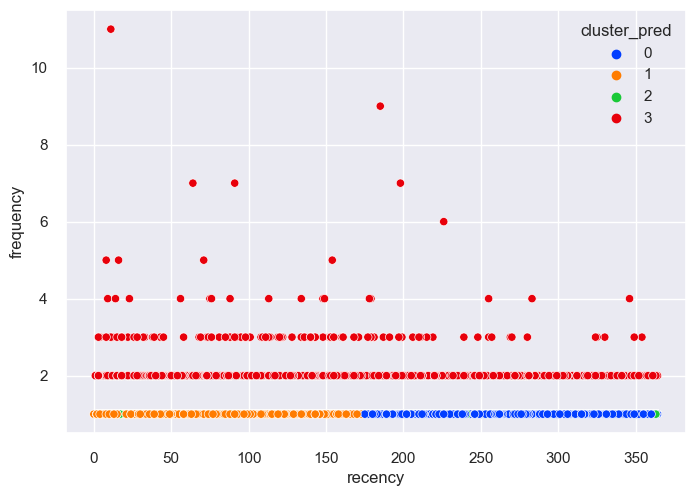

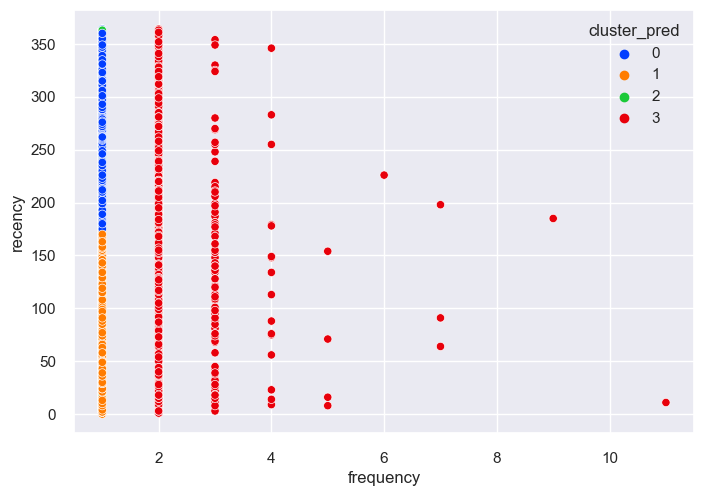

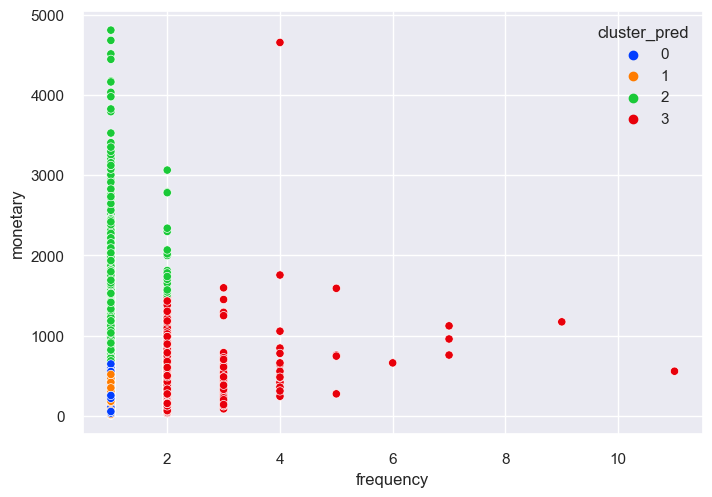

In [308]:
# dfrfmpred['recency'] = clusters_scaled['récence']
# dfrfmpred['frequency'] = clusters_scaled['fréquence']
# dfrfmpred['monetary_value'] = clusters_scaled['monétaire']
#dfrfmpred['cluster'] = clusters_scaled['cluster_pred']

# dfrfmpred.drop(['récence', 'fréquence', 'monétaire', 'cluster_pred'])

#sns.displot(dfrfmpred.recency)

sns.scatterplot(x=clusters_scaled.recency, y=clusters_scaled.monetary, hue=clusters_scaled.cluster_pred, palette='bright')
plt.show()
sns.scatterplot(x=clusters_scaled.recency, y=clusters_scaled.frequency, hue=clusters_scaled.cluster_pred, palette='bright')
plt.show()
sns.scatterplot(x=clusters_scaled.frequency, y=clusters_scaled.recency, hue=clusters_scaled.cluster_pred, palette='bright')
plt.show()
sns.scatterplot(x=clusters_scaled.frequency, y=clusters_scaled.monetary, hue=clusters_scaled.cluster_pred, palette='bright')
plt.show()


### Validation

We will use Silhoutte score to validate our clusters.

Silhouette Score: 0.498


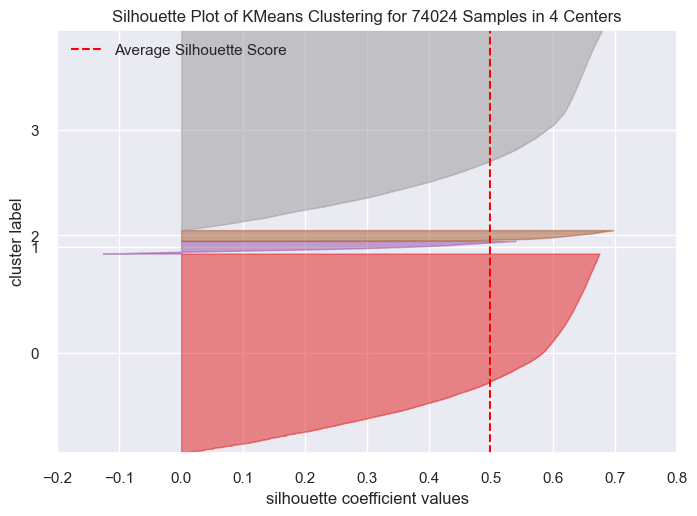

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 74024 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [286]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()   
   

### Cluster Profiling

We are going to analyse and understand our clusters.

In [287]:
rfm1['cluster']= clusters_scaled['cluster_pred']
rfm1['level']=rfm['level']

rfm1.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max','count']
})

C:\Users\Zbook\AppData\Local\Temp\ipykernel_13496\3470046792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm1['cluster']= clusters_scaled['cluster_pred']
C:\Users\Zbook\AppData\Local\Temp\ipykernel_13496\3470046792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm1['level']=rfm['level']


recency           frequency             monetary                   \
               mean  min  max      mean min max         mean     min      max   
cluster                                                                         
0        260.160284  175  364  1.000000   1   1   131.782503   10.07   649.15   
1         89.841857    0  176  1.000000   1   1   134.315583    9.59   656.81   
2        176.895025    3  364  1.008672   1   2  1079.651652  591.87  4809.44   
3        158.929063    1  364  2.097406   2  11   296.686554   34.97  4655.91   

                
         count  
cluster         
0        34963  
1        34981  
2         2191  
3         1889

groupe 0 : inactif
groupe 1 : bon 
groupe 2 : meilleur
groupe 3 : moyen

From the above summary we get to know that,
    
- **Cluster 0** is the most valuable group of customers with **highest mean frequency** (purchase most often), **least mean recency** (has recently purchased from the company) and the **highest mean monetary** (high purchasing amount).
    
    
- On the other hand, **Cluster 2** is the group of customers with **least frequency** and **monetary** and **recency values**.


In [288]:
rfm1.head(20)

,recency,frequency,monetary,cluster,level
0,141,1,100.46,1,Bon
1,28,1,276.20,1,Meilleur
2,142,1,143.59,1,Bon
3,306,1,41.09,0,Inactif
4,291,1,39.09,0,Inactif
5,144,1,162.03,1,Bon
6,115,1,99.90,1,Bon
7,335,1,42.38,0,Inactif
8,192,1,76.76,0,Moyen
9,211,1,75.08,0,Moyen


### Nature of the cluster

We need to check whether the predicted clusters are **homogeneous** or **heterogeneous** in nature.

In [289]:
rfm1.groupby(['cluster','level']).size()

cluster  level   
0        Bon         14920
         Inactif       587
         Meilleur     3290
         Moyen       16166
1        Bon         16129
         Meilleur    14773
         Moyen        4079
2        Bon           816
         Meilleur     1279
         Moyen          96
3        Bon           234
         Meilleur     1652
         Moyen           3
dtype: int64

### Observations

**Cluster 1** is **heterogenous** in nature. It comprises **Active, Average and Good customers**.

**Cluster 0** is **homogeneous** in nature and has **Active customers** in majority.
 

### Comparing RFM analysis and Clusters

**Transforming** and storing the RFM values for plotting a snake plot.

In [290]:
rfm_scaled=pd.DataFrame()
rfm_scaled=rfm1.copy()
scaler=StandardScaler()
rfm_scaled[['recency', 'frequency','monetary']] = scaler.fit_transform(rfm_scaled[['recency', 'frequency','monetary']])
rfm_scaled['cust_id']=rfm1.index

In [291]:
rfm_scaled.head()

,recency,frequency,monetary,cluster,level,cust_id
0,-0.338183,-0.149567,-0.300862,1,Bon,0
1,-1.474636,-0.149567,0.515299,1,Meilleur,1
2,-0.328126,-0.149567,-0.100561,1,Bon,2
3,1.321239,-0.149567,-0.576585,0,Inactif,3
4,1.170383,-0.149567,-0.585873,0,Inactif,4


#### Melting the dataframe

In [292]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['cust_id', 'level', 'cluster'], var_name = 'metrics', value_name = 'value')
rfm_melted.head()

,cust_id,level,cluster,metrics,value
0,0,Bon,1,recency,-0.338183
1,1,Meilleur,1,recency,-1.474636
2,2,Bon,1,recency,-0.328126
3,3,Inactif,0,recency,1.321239
4,4,Inactif,0,recency,1.170383


### Snake plot based on RFM segmentation

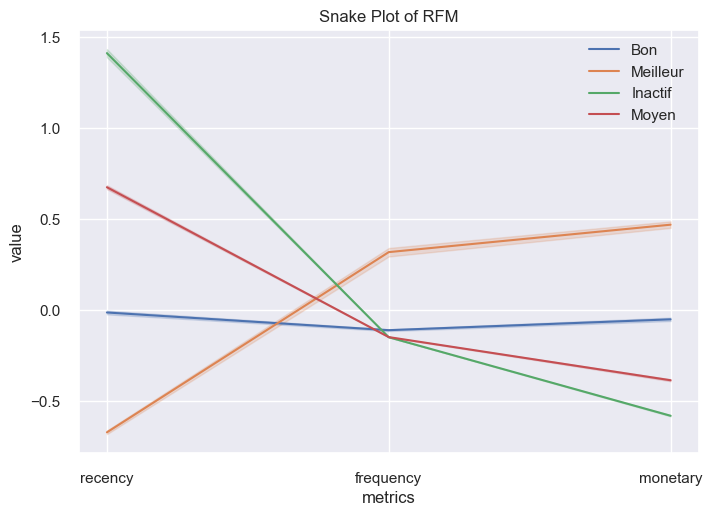

In [293]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')


### Snake plot with clusters using K-Means

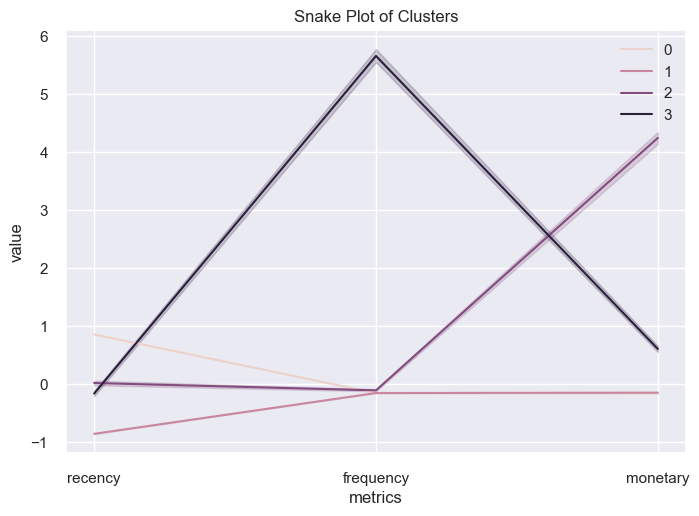

In [294]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted)
plt.title('Snake Plot of Clusters')
plt.legend(loc = 'upper right')

## Conclusion

We made two kinds of segmentation, RFM quantiles and K-Means clustering methods.

Customers have been categorized into 4 buckets based on Recency, Frequency and Monetary value of their purchases. Targeted strategy to be applied for each customer segment.

With the result,

* We figured out ‘best’ customers, the most profitable group.
* This also tells us on which customer group we should focus on and to whom to give special offers or promotions among the customers.
* We can select the best communication channel for each segment and improve new marketing strategies.